<a href="https://colab.research.google.com/github/Manikumar1999/Project-Facial-Emotion-Recognition-Using-Deep-Learning/blob/main/Face_emotion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.2 MB/s eta 0:00:00


# Libraries

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import RMSprop
import keras_tuner as kt
from tensorflow.keras.applications import InceptionV3


# Setup the data

In [ ]:
# Path to the ZIP file in Google Drive
zip_file_path = '/content/archive.zip'
# Path where the data will be extracted
extract_to_path = '/content/Data'
# Unzipping the file
if not os.path.exists(extract_to_path):  # Check if already unzipped
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
else:
    print(f"Data already extracted at: {extract_to_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/content/archive.zip'

In [ ]:
emotion_main_directory = '/content/Data'

# Initial analysis

In [ ]:
def load_and_display_samples(base_dir, dataset_type="train"):
    """
    Loads data from the directory structure and displays sample images for each class.

    Parameters:
    - base_dir (str): Path to the main directory containing train/test folders.
    - dataset_type (str): Either "train" or "test" to specify which dataset to load.

    Returns:
    - None: Displays sample images using matplotlib.
    """
    # Define the dataset path
    dataset_path = os.path.join(base_dir, dataset_type)

    # Get the list of emotion categories (subdirectories)
    emotion_classes = sorted(os.listdir(dataset_path))

    # Plot sample images
    plt.figure(figsize=(16, 12))
    for idx, emotion in enumerate(emotion_classes):
        emotion_path = os.path.join(dataset_path, emotion)

        # Get a random image from the class directory
        sample_image_name = random.choice(os.listdir(emotion_path))
        sample_image_path = os.path.join(emotion_path, sample_image_name)

        # Open and display the image
        image = Image.open(sample_image_path)

        plt.subplot(2, 4, idx + 1)
        plt.imshow(image, cmap="gray" if image.mode == "L" else None)
        plt.title(emotion.capitalize())
        plt.axis("off")

    plt.suptitle(f"Sample Images from {dataset_type.capitalize()} Dataset", fontsize=16)
    plt.tight_layout()
    plt.show()

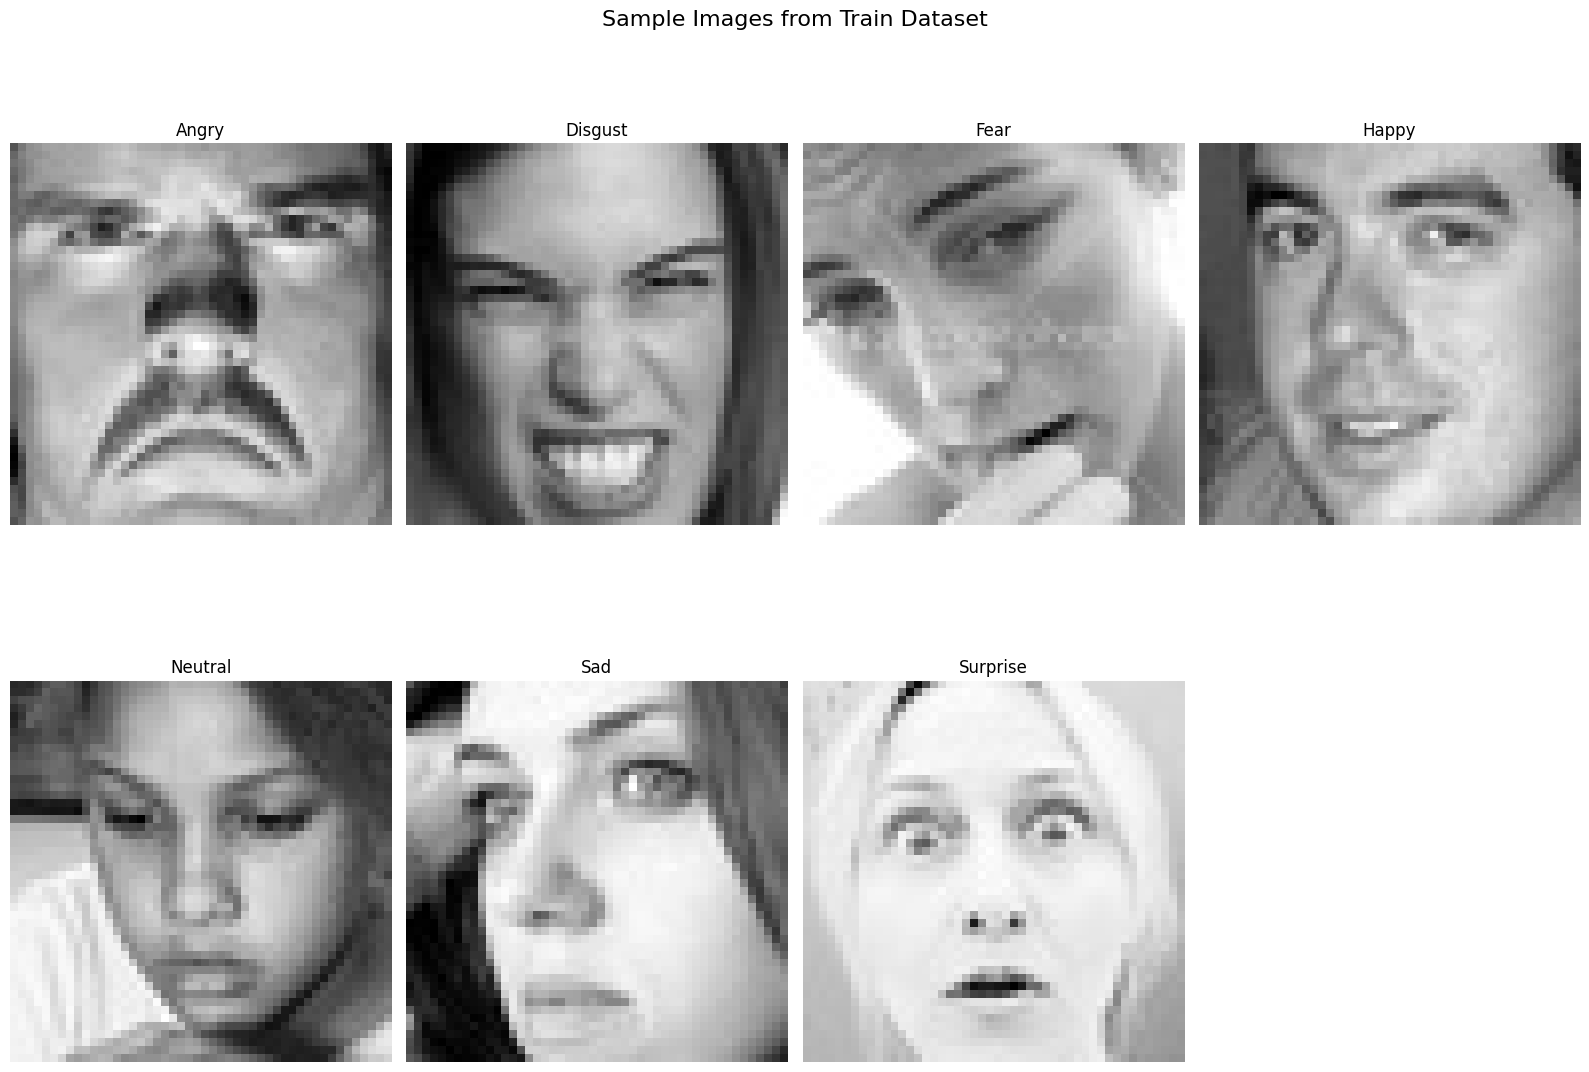

In [ ]:
# display the images from train data
load_and_display_samples(emotion_main_directory, dataset_type="train")

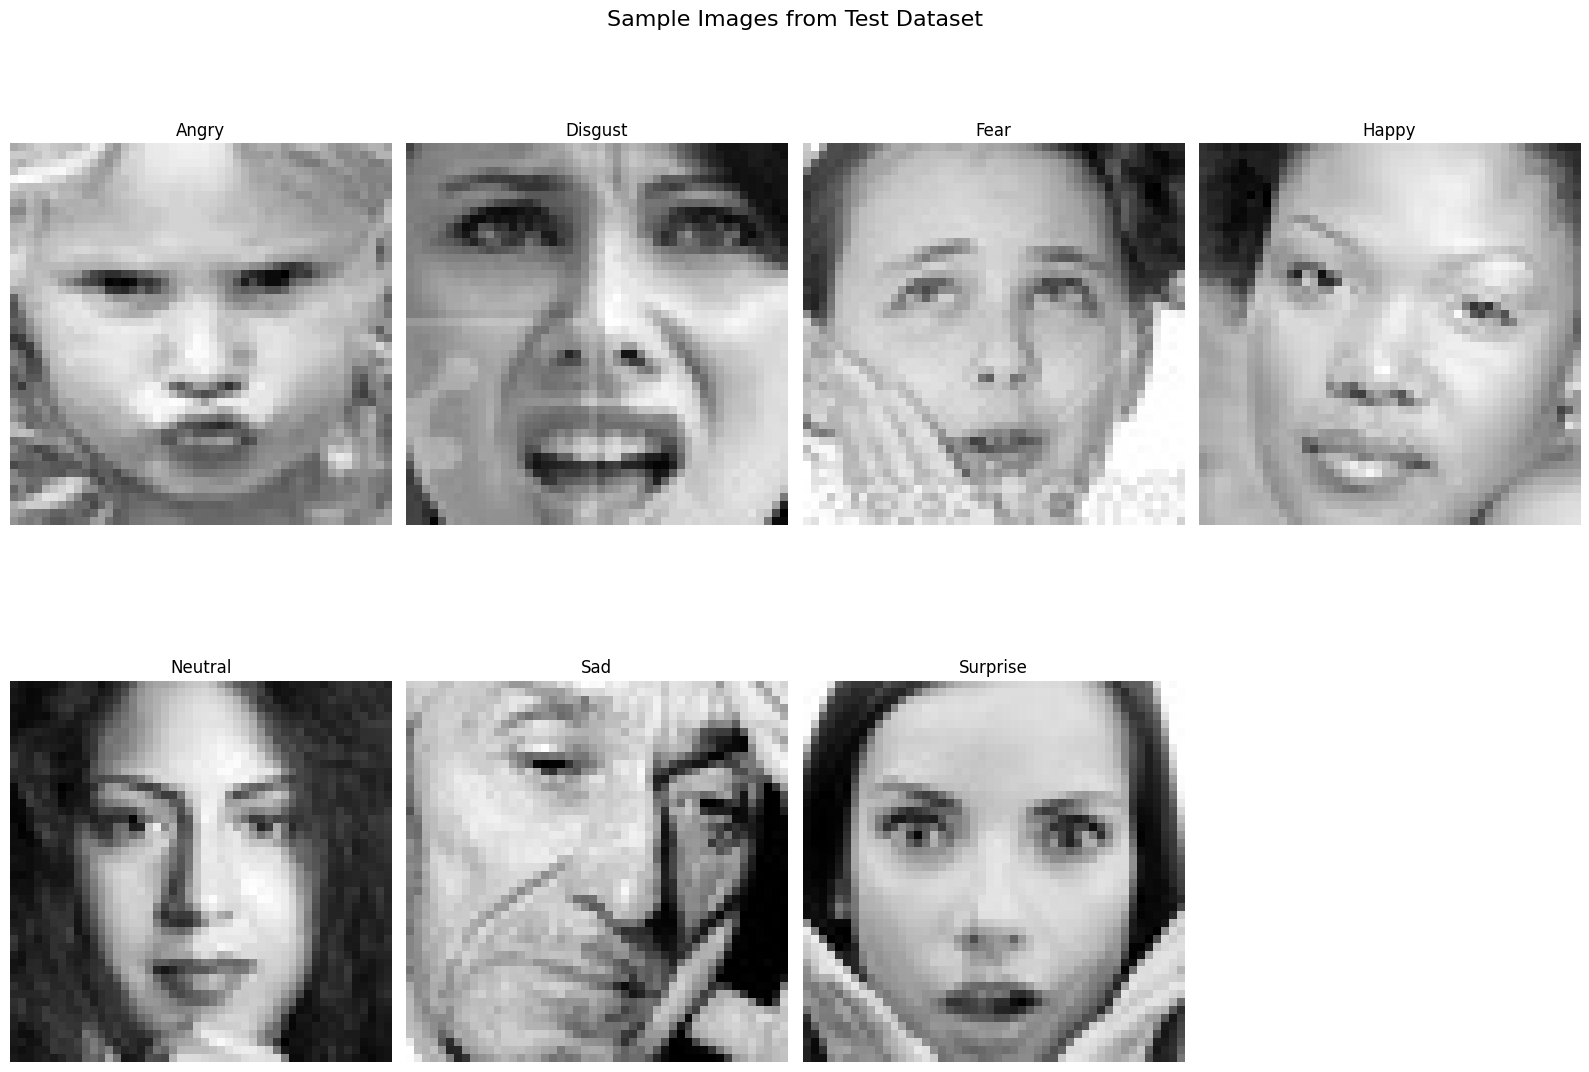

In [ ]:
# display the images from test data
load_and_display_samples(emotion_main_directory, dataset_type="test")

In [ ]:
def print_random_image_sizes(base_dir, dataset_type="train", sample_count=10):
    """
    Randomly samples images from the dataset and prints their sizes.

    Parameters:
    - base_dir (str): Path to the main directory containing train/test folders.
    - dataset_type (str): Either "train" or "test" to specify which dataset to load.
    - sample_count (int): Number of random images to sample.

    Returns:
    - None: Prints the sizes of the sampled images.
    """
    # Define the dataset path
    dataset_path = os.path.join(base_dir, dataset_type)

    # Get the list of emotion categories
    emotion_classes = sorted(os.listdir(dataset_path))

    # Collect all image paths
    all_image_paths = []
    for emotion in emotion_classes:
        emotion_path = os.path.join(dataset_path, emotion)
        image_files = [os.path.join(emotion_path, img) for img in os.listdir(emotion_path)]
        all_image_paths.extend(image_files)

    # Randomly sample image paths
    sampled_images = random.sample(all_image_paths, sample_count)

    # Print the sizes of sampled images
    print(f"Randomly sampled {sample_count} image sizes from the {dataset_type} dataset:\n")
    for img_path in sampled_images:
        with Image.open(img_path) as img:
            print(f"Image: {os.path.basename(img_path)}, Size: {img.size}")  # img.size returns (width, height)

In [ ]:
print_random_image_sizes(emotion_main_directory, dataset_type="train", sample_count=10)

Randomly sampled 10 image sizes from the train dataset:

Image: Training_8600342.jpg, Size: (48, 48)
Image: Training_16149285.jpg, Size: (48, 48)
Image: Training_50607806.jpg, Size: (48, 48)
Image: Training_50676521.jpg, Size: (48, 48)
Image: Training_5578301.jpg, Size: (48, 48)
Image: Training_11036720.jpg, Size: (48, 48)
Image: Training_59620433.jpg, Size: (48, 48)
Image: Training_73550785.jpg, Size: (48, 48)
Image: Training_1784938.jpg, Size: (48, 48)
Image: Training_56432944.jpg, Size: (48, 48)


In [ ]:
print_random_image_sizes(emotion_main_directory, dataset_type="test", sample_count=10)

Randomly sampled 10 image sizes from the test dataset:

Image: PrivateTest_81084455.jpg, Size: (48, 48)
Image: PrivateTest_49383844.jpg, Size: (48, 48)
Image: PublicTest_67808581.jpg, Size: (48, 48)
Image: PrivateTest_80005081.jpg, Size: (48, 48)
Image: PrivateTest_99871365.jpg, Size: (48, 48)
Image: PublicTest_90902282.jpg, Size: (48, 48)
Image: PrivateTest_69777499.jpg, Size: (48, 48)
Image: PublicTest_14734177.jpg, Size: (48, 48)
Image: PublicTest_74596575.jpg, Size: (48, 48)
Image: PrivateTest_45784436.jpg, Size: (48, 48)


# Preprocessing

In [ ]:
def create_dataframe(base_dir, dataset_type="train"):
    """
    Creates a DataFrame containing file paths and labels for a dataset.

    Parameters:
    - base_dir (str): Path to the main directory containing train/test folders.
    - dataset_type (str): Either "train" or "test" to specify which dataset to process.

    Returns:
    - pd.DataFrame: A DataFrame with columns 'File Path' and 'Label'.
    """
    # Define the dataset path
    dataset_path = os.path.join(base_dir, dataset_type)

    # Initialize lists to store file paths and labels
    file_paths = []
    labels = []

    # Traverse emotion categories (subdirectories)
    for label in sorted(os.listdir(dataset_path)):
        emotion_path = os.path.join(dataset_path, label)
        if os.path.isdir(emotion_path):
            for img_file in os.listdir(emotion_path):
                file_paths.append(os.path.join(emotion_path, img_file))
                labels.append(label)

    # Create DataFrame
    data = {"File Path": file_paths, "Label": labels}
    df = pd.DataFrame(data)

    # Shuffle the DataFrame
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    return df

In [ ]:
exp_train_df = create_dataframe(emotion_main_directory, dataset_type="train")
exp_test_df = create_dataframe(emotion_main_directory, dataset_type="test")

# Display the first few rows of the DataFrame
print("Train DataFrame:")
print(exp_train_df.head())
print("\nTest DataFrame:")
print(exp_test_df.head())

Train DataFrame:
                                           File Path     Label
0      /content/Data/train/fear/Training_1995343.jpg      fear
1    /content/Data/train/happy/Training_64923211.jpg     happy
2  /content/Data/train/surprise/Training_42793883...  surprise
3     /content/Data/train/fear/Training_81755794.jpg      fear
4  /content/Data/train/surprise/Training_54166435...  surprise

Test DataFrame:
                                           File Path    Label
0  /content/Data/test/neutral/PrivateTest_2398703...  neutral
1  /content/Data/test/happy/PrivateTest_97883091.jpg    happy
2  /content/Data/test/neutral/PrivateTest_2968474...  neutral
3    /content/Data/test/sad/PrivateTest_53800861.jpg      sad
4     /content/Data/test/fear/PublicTest_8877539.jpg     fear


In [ ]:
# size of the trainset
exp_train_df.shape

(28709, 2)

In [ ]:
# count the label wise
exp_train_df['Label'].value_counts()

,count
Label,
happy,7215
neutral,4965
sad,4830
fear,4097
angry,3995
surprise,3171
disgust,436


In [ ]:
# size of test dataset
exp_test_df.shape

(7178, 2)

In [ ]:
# count the label wise
exp_test_df['Label'].value_counts()

,count
Label,
happy,1774
sad,1247
neutral,1233
fear,1024
angry,958
surprise,831
disgust,111


In [ ]:
def balance_data(df, target_count=4000):
    """
    Balance the dataset using a combination of under-sampling and over-sampling
    to achieve a target count for each class.

    Parameters:
    - df (pd.DataFrame): DataFrame containing file paths and labels.
    - target_count (int): Desired number of samples per class.

    Returns:
    - balanced_df (pd.DataFrame): DataFrame with balanced samples (file paths and labels).
    """
    # Step 1: Under-sample classes with more than the target count
    undersampler = RandomUnderSampler(
        sampling_strategy={label: min(count, target_count) for label, count in df['Label'].value_counts().items()},
        random_state=42
    )
    X_under, y_under = undersampler.fit_resample(df[['File Path']], df['Label'])

    # Step 2: Over-sample classes with fewer than the target count
    oversampler = RandomOverSampler(
        sampling_strategy={label: target_count for label, count in pd.Series(y_under).value_counts().items()},
        random_state=42
    )
    X_balanced, y_balanced = oversampler.fit_resample(X_under, y_under)

    # Step 3: Create a balanced DataFrame with file paths and resampled labels
    balanced_df = pd.DataFrame({
        'File Path': X_balanced['File Path'].values,
        'Label': y_balanced
    })

    return balanced_df

In [ ]:
balanced_train_df = balance_data(exp_train_df)

# Display class counts after balancing
print("dataset size is :",balanced_train_df.shape)
print("Class distribution after SMOTE and Undersampling:")
balanced_train_df["Label"].value_counts()

dataset size is : (28000, 2)
Class distribution after SMOTE and Undersampling:


,count
Label,
angry,4000
disgust,4000
fear,4000
happy,4000
neutral,4000
sad,4000
surprise,4000


In [ ]:
def create_data_generators(train_df, test_df, image_size=(48, 48), batch_size=64, validation_split=0.2):
    """
    Split train_df into train and validation sets and create data generators for train, validation, and test.

    Parameters:
    - train_df (pd.DataFrame): DataFrame for the training data with image paths and labels.
    - test_df (pd.DataFrame): DataFrame for the test data with image paths and labels.
    - image_size (tuple): Desired image size for resizing (default is (48, 48)).
    - batch_size (int): Batch size for the data generators.
    - validation_split (float): Fraction of the training data to be used as validation data.

    Returns:
    - train_generator (DirectoryIterator): Generator for the training data.
    - validation_generator (DirectoryIterator): Generator for the validation data.
    - test_generator (DirectoryIterator): Generator for the test data.
    """

    # Split train_df into train and validation sets
    train_df, val_df = train_test_split(train_df, test_size=validation_split, stratify=train_df['Label'], random_state=42)

    # Create ImageDataGenerator for data augmentation in training
    train_datagen = ImageDataGenerator(
        rescale=1./255,       # Normalize pixel values to [0, 1]
        rotation_range=40,    # Randomly rotate images
        width_shift_range=0.2,  # Randomly shift images horizontally
        height_shift_range=0.2,  # Randomly shift images vertically
        shear_range=0.2,      # Apply random shearing transformations
        zoom_range=0.2,       # Random zoom
        horizontal_flip=True,  # Randomly flip images horizontally
        fill_mode='nearest',   # Fill empty pixels after transformations
        validation_split=validation_split  # Use validation split to create a validation generator
    )

    # Create ImageDataGenerator for validation (without heavy augmentation)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create ImageDataGenerator for test set (no augmentation)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Create the train, validation, and test generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File Path',   # Column containing the file paths of images
        y_col='Label',       # Column containing the labels
        target_size=image_size,  # Resize images to the target size
        batch_size=batch_size,
        color_mode='grayscale',  # Ensure images are loaded as grayscale
        class_mode='categorical',  # For multi-class classification
        shuffle=True,        # Shuffle the data
        seed=42              # Random seed for reproducibility
    )

    validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='File Path',   # Column containing the file paths of images
        y_col='Label',       # Column containing the labels
        target_size=image_size,  # Resize images to the target size
        batch_size=batch_size,
        color_mode='grayscale',  # Ensure images are loaded as grayscale
        class_mode='categorical',  # For multi-class classification
        shuffle=False,       # Do not shuffle validation data
        seed=42              # Random seed for reproducibility
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File Path',   # Column containing the file paths of images
        y_col='Label',       # Column containing the labels
        target_size=image_size,  # Resize images to the target size
        batch_size=batch_size,
        color_mode='grayscale',  # Ensure images are loaded as grayscale
        class_mode='categorical',  # For multi-class classification
        shuffle=False,       # Do not shuffle test data
        seed=42              # Random seed for reproducibility
    )

    return train_generator, validation_generator, test_generator

In [ ]:
train_generator, validation_generator, test_generator = create_data_generators(balanced_train_df, exp_test_df)

Found 22400 validated image filenames belonging to 7 classes.
Found 5600 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


# Model implementation

## CNN

In [ ]:
def build_cnn_model(input_shape=(48, 48, 1), num_classes=7):
    model = models.Sequential()

    # Add layers to the model
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))

    # Output layer with softmax activation (for multi-class classification)
    model.add(layers.Dense(num_classes, activation='softmax'))  # 7 output classes

    # Compile the model with categorical crossentropy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
def train_model_with_early_stop(model, train_generator, validation_generator, epochs=50):
    """
    Train the model with early stopping.

    Parameters:
    - model (tf.keras.Model): The model to be trained.
    - train_generator: The training data generator.
    - validation_generator: The validation data generator.
    - epochs (int): The number of epochs to train the model.

    Returns:
    - history (History object): Training history object containing the loss and accuracy over epochs.
    """
    # Define EarlyStopping callback
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stop]
    )

    return history

In [ ]:
cnn_model = build_cnn_model()
cnn_emo_history = train_model_with_early_stop(cnn_model,train_generator, validation_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 69ms/step - accuracy: 0.1589 - loss: 1.9396 - val_accuracy: 0.2421 - val_loss: 1.8626
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - accuracy: 0.2276 - loss: 1.8848 - val_accuracy: 0.2682 - val_loss: 1.8368
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 57ms/step - accuracy: 0.2523 - loss: 1.8553 - val_accuracy: 0.2950 - val_loss: 1.7736
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.2637 - loss: 1.8300 - val_accuracy: 0.3143 - val_loss: 1.7207
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 63ms/step - accuracy: 0.2922 - loss: 1.7845 - val_accuracy: 0.3629 - val_loss: 1.6432
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.3166 - loss: 1.7357 - val_accuracy: 0.3902 - val_loss: 1.6058
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.3408 - loss: 1.7013 - val_accuracy: 0.4095 - val_loss: 1.5377
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.3634 - loss: 1.6539 - val_accurac

In [ ]:
def plot_history_and_evaluate(model, history, test_generator, model_name):
    """
    Plot training history and generate classification report and confusion matrix based on test data.

    Parameters:
    - model (tf.keras.Model): The trained model.
    - history (History object): History object from model training.
    - test_generator: The test data generator.
    - model_name (str): The name of the model being evaluated.
    """
    # Plot training history (Loss and Accuracy)
    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Evaluate the model on the test data
    test_labels = test_generator.classes  # True labels

    # Get the number of steps
    test_steps = len(test_generator)

    # Get model predictions
    test_predictions = model.predict(test_generator, steps=test_steps, verbose=1)

    # Flatten the predictions if necessary
    test_predictions = np.argmax(test_predictions, axis=1)

    # Ensure that the number of labels and predictions are the same
    if len(test_labels) != len(test_predictions):
        print(f"Warning: Number of labels ({len(test_labels)}) does not match number of predictions ({len(test_predictions)}).")

    # Classification Report
    print(f"Classification Report for {model_name}:")
    print(classification_report(test_labels, test_predictions))

    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

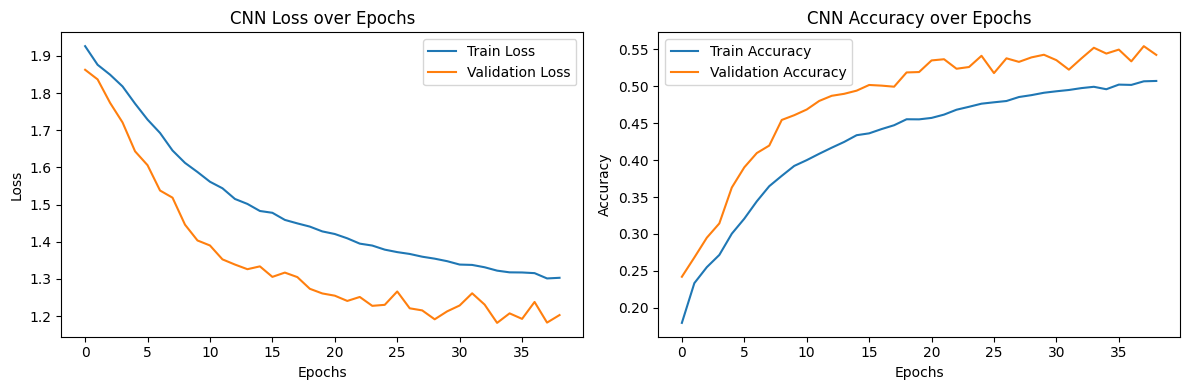

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.43      0.40      0.41       958
           1       0.15      0.68      0.25       111
           2       0.36      0.21      0.26      1024
           3       0.83      0.68      0.75      1774
           4       0.45      0.58      0.51      1233
           5       0.45      0.34      0.39      1247
           6       0.55      0.81      0.65       831

    accuracy                           0.51      7178
   macro avg       0.46      0.53      0.46      7178
weighted avg       0.54      0.51      0.51      7178



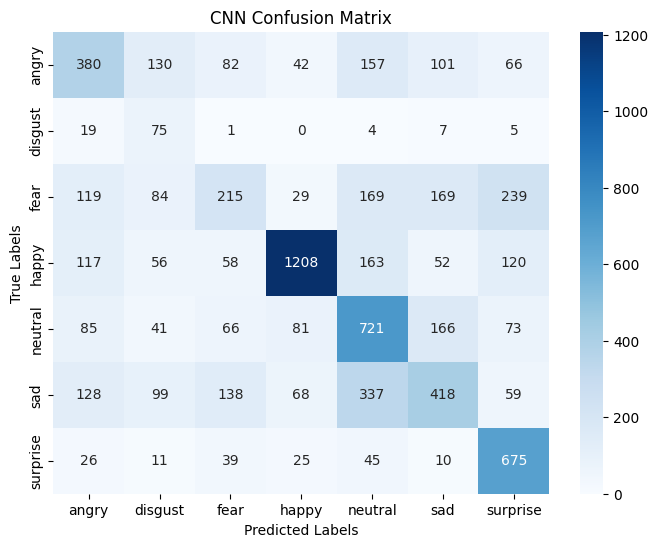

In [ ]:
plot_history_and_evaluate(cnn_model, cnn_emo_history, test_generator,'CNN')

## ResNet50

In [ ]:
def build_resnet50_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Build a ResNet50-based model for grayscale image classification.
    """
    # Load ResNet50 base model without top layers
    base_model = ResNet50(weights='imagenet', include_top=False)

    # Change input layer to accept grayscale images
    input_layer = layers.Input(shape=input_shape)
    grayscale_to_rgb = layers.Conv2D(3, (1, 1), activation='linear', name='grayscale_to_rgb')(input_layer)

    # Connect ResNet50 with new input
    x = base_model(grayscale_to_rgb, training=False)

    # Add additional layers on top
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    # Build the complete model
    model = models.Model(inputs=input_layer, outputs=output_layer)

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
resnet_model = build_resnet50_model()  # Build the model first
res_emo_history = train_model_with_early_stop(resnet_model,train_generator, validation_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 91s 99ms/step - accuracy: 0.1851 - loss: 2.0666 - val_accuracy: 0.1429 - val_loss: 1.9989
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.3331 - loss: 1.7153 - val_accuracy: 0.1432 - val_loss: 2.0884
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 29s 82ms/step - accuracy: 0.3596 - loss: 1.6613 - val_accuracy: 0.3436 - val_loss: 1.7424
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.3860 - loss: 1.6063 - val_accuracy: 0.2809 - val_loss: 1.9436
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 45s 91ms/step - accuracy: 0.4284 - loss: 1.5033 - val_accuracy: 0.2546 - val_loss: 1.9656
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 80ms/step - accuracy: 0.4314 - loss: 1.5050 - val_accuracy: 0.4384 - val_loss: 1.4706
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 28s 80ms/step - accuracy: 0.4351 - loss: 1.4860 - val_accuracy: 0.4695 - val_loss: 1.3882
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━

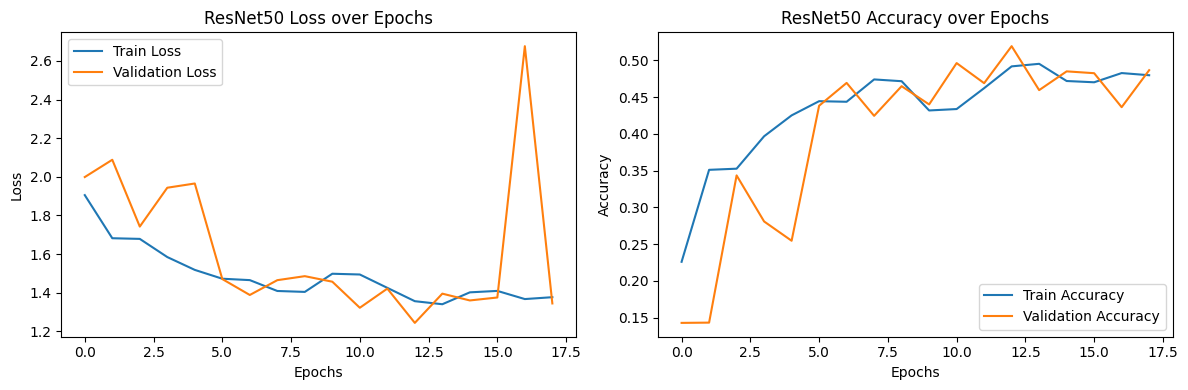

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.48      0.30      0.37       958
           1       0.21      0.63      0.32       111
           2       0.31      0.07      0.11      1024
           3       0.78      0.78      0.78      1774
           4       0.42      0.67      0.51      1233
           5       0.44      0.33      0.38      1247
           6       0.50      0.81      0.62       831

    accuracy                           0.52      7178
   macro avg       0.45      0.51      0.44      7178
weighted avg       0.51      0.52      0.49      7178



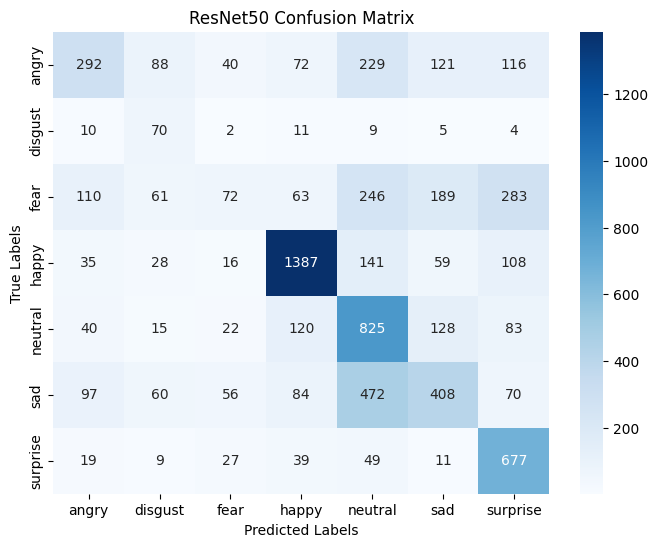

In [ ]:
plot_history_and_evaluate(resnet_model, res_emo_history, test_generator,'ResNet50')

## VGG16

In [ ]:
def build_vgg16_model(input_shape=(48, 48, 1), num_classes=7):
    # Create a Sequential model
    model = models.Sequential()

    # Add a Conv2D layer to convert grayscale to RGB
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Load the VGG16 model with pretrained weights
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    # Freeze the layers of the base model
    base_model.trainable = False

    # Add the base model
    model.add(base_model)

    # Add classification layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
vgg_model = build_vgg16_model()
vgg_emo_history = train_model_with_early_stop(vgg_model,train_generator, validation_generator)

       0/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 83ms/step - accuracy: 0.1817 - loss: 1.9614 - val_accuracy: 0.2423 - val_loss: 1.8686
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.2303 - loss: 1.8825 - val_accuracy: 0.2682 - val_loss: 1.8170
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 74ms/step - accuracy: 0.2477 - loss: 1.8601 - val_accuracy: 0.2761 - val_loss: 1.8096
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 39s 69ms/step - accuracy: 0.2571 - loss: 1.8422 - val_accuracy: 0.2977 - val_loss: 1.7650
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 41s 71ms/step - accuracy: 0.2678 - loss: 1.8279 - val_accuracy: 0.2993 - val_loss: 1.7785
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.2751 - loss: 1.8121 - val_accuracy: 0.3014 - val_loss: 1.7635
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 67ms/step - accuracy: 0.2720 - loss: 1.8142 - val_accuracy: 0.3168 - val_loss: 1.7383
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━

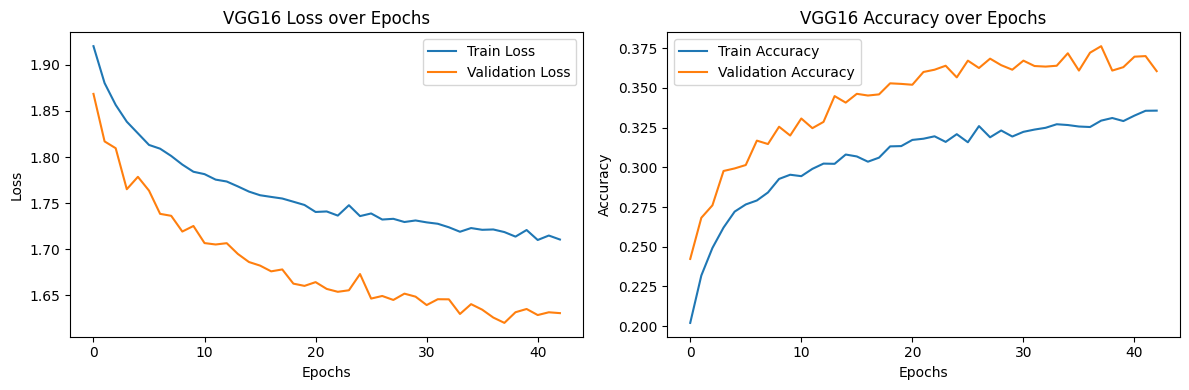

113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.25      0.18      0.21       958
           1       0.07      0.60      0.13       111
           2       0.29      0.10      0.15      1024
           3       0.49      0.56      0.52      1774
           4       0.36      0.34      0.35      1233
           5       0.41      0.14      0.21      1247
           6       0.37      0.71      0.49       831

    accuracy                           0.35      7178
   macro avg       0.32      0.38      0.29      7178
weighted avg       0.37      0.35      0.33      7178



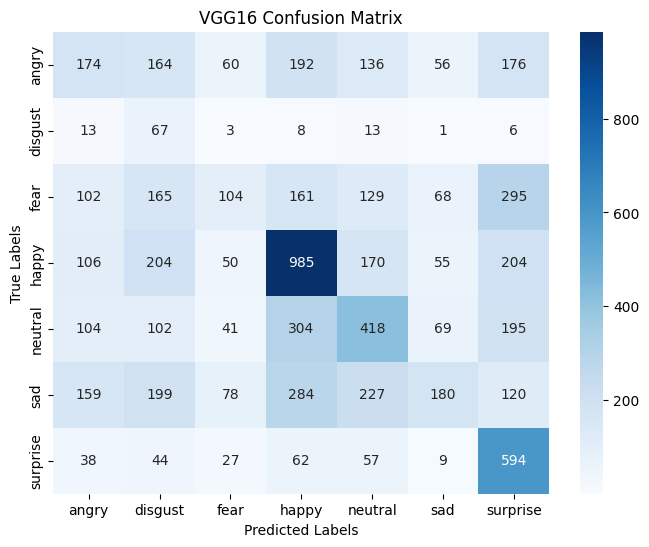

In [ ]:
plot_history_and_evaluate(vgg_model, vgg_emo_history, test_generator,'VGG16')

## NASNet

In [ ]:
def build_nasnet_model(input_shape=(48, 48, 1), num_classes=7):
    # Create a Sequential model
    model = models.Sequential()

    # Add a Conv2D layer to convert grayscale to RGB
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Load the pre-trained NASNetMobile model
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    # Freeze the layers of the base model to retain the pre-trained features
    base_model.trainable = False

    # Add the base model
    model.add(base_model)

    # Add classification layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
nas_model = build_nasnet_model()
nas_emo_history = train_model_with_early_stop(nas_model,train_generator, validation_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 86s 143ms/step - accuracy: 0.1701 - loss: 2.0640 - val_accuracy: 0.2193 - val_loss: 1.9017
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 43s 77ms/step - accuracy: 0.2044 - loss: 1.9222 - val_accuracy: 0.2282 - val_loss: 1.8911
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.2188 - loss: 1.9005 - val_accuracy: 0.2484 - val_loss: 1.8664
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - accuracy: 0.2314 - loss: 1.8861 - val_accuracy: 0.2414 - val_loss: 1.8675
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 75ms/step - accuracy: 0.2307 - loss: 1.8872 - val_accuracy: 0.2636 - val_loss: 1.8416
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.2394 - loss: 1.8766 - val_accuracy: 0.2582 - val_loss: 1.8310
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 27s 76ms/step - accuracy: 0.2455 - loss: 1.8689 - val_accuracy: 0.2738 - val_loss: 1.8354
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━

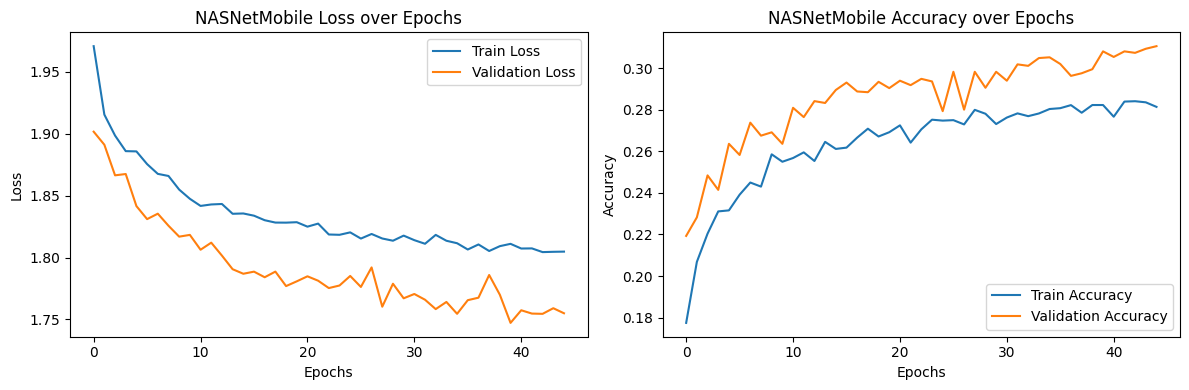

113/113 ━━━━━━━━━━━━━━━━━━━━ 28s 150ms/step
Classification Report for NASNetMobile:
              precision    recall  f1-score   support

           0       0.18      0.07      0.10       958
           1       0.05      0.51      0.09       111
           2       0.22      0.02      0.03      1024
           3       0.42      0.60      0.49      1774
           4       0.28      0.18      0.22      1233
           5       0.33      0.18      0.23      1247
           6       0.32      0.61      0.42       831

    accuracy                           0.30      7178
   macro avg       0.26      0.31      0.23      7178
weighted avg       0.30      0.30      0.27      7178



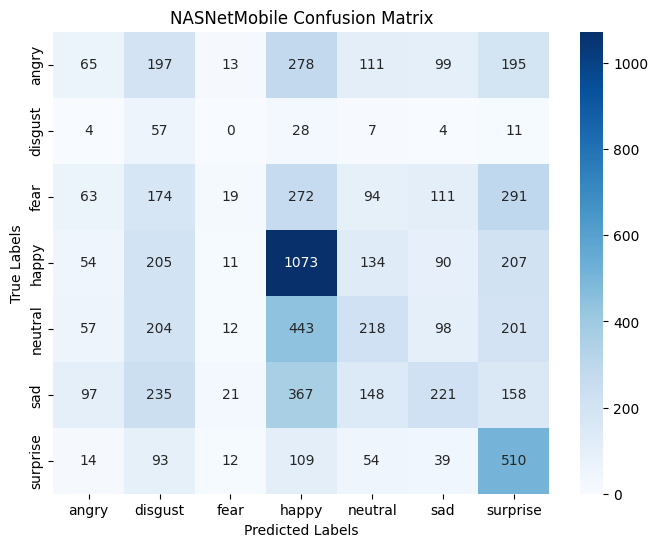

In [ ]:
plot_history_and_evaluate(nas_model, nas_emo_history, test_generator,'NASNetMobile')

# Fine-tuning

## CNN

In [ ]:
def build_cnn_model(hp):
    model = models.Sequential()

    # First convolutional block
    model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=16, max_value=64, step=16),
        (3, 3),
        activation='relu',
        input_shape=(48, 48, 1)
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Second convolutional block
    model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=32, max_value=128, step=32),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Third convolutional block
    model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=64, max_value=256, step=64),
        (3, 3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten and Dense layers with regularization and dropout
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('dense_reg', min_value=0.01, max_value=0.1, step=0.01))
    ))
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)))

    # Output layer with softmax activation (for multi-class classification)
    model.add(layers.Dense(7, activation='softmax'))  # 7 output classes

    # Compile the model with hyperparameters for the learning rate
    model.compile(
        optimizer=RMSprop(
            learning_rate=hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
# Define the hyperparameter search space
tuner = kt.Hyperband(
    build_cnn_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=2,
    directory='my_dir',
    project_name='cnn_tuning',
    executions_per_trial=1
)

# Start the hyperparameter search
tuner.search(train_generator, validation_data=validation_generator, epochs=5, callbacks=[early_stopping])

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best hyperparameters: {best_hps.values}')

Trial 17 Complete [00h 02m 03s]
val_accuracy: 0.1428571492433548

Best val_accuracy So Far: 0.22910714149475098
Total elapsed time: 00h 20m 29s
Best hyperparameters: {'conv_1_filters': 16, 'conv_2_filters': 64, 'conv_3_filters': 64, 'dense_units': 128, 'dense_reg': 0.01, 'dropout': 0.30000000000000004, 'learning_rate': 0.0002545349849893049, 'tuner/epochs': 5, 'tuner/initial_epoch': 3, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0007'}


In [ ]:
# Define EarlyStopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=20, min_lr=0.00001)

In [ ]:
cnn_ft_history = best_model.fit(train_generator, validation_data=validation_generator, epochs=200, callbacks=[early_stopping])

Epoch 1/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - accuracy: 0.2075 - loss: 1.9140 - val_accuracy: 0.2252 - val_loss: 1.8922
Epoch 2/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.2242 - loss: 1.9008 - val_accuracy: 0.2554 - val_loss: 1.8669
Epoch 3/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - accuracy: 0.2233 - loss: 1.8968 - val_accuracy: 0.2523 - val_loss: 1.8635
Epoch 4/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - accuracy: 0.2322 - loss: 1.8923 - val_accuracy: 0.2643 - val_loss: 1.8486
Epoch 5/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.2382 - loss: 1.8876 - val_accuracy: 0.2587 - val_loss: 1.8537
Epoch 6/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 54ms/step - accuracy: 0.2502 - loss: 1.8772 - val_accuracy: 0.2804 - val_loss: 1.8272
Epoch 7/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.2444 - loss: 1.8820 - val_accuracy: 0.2868 - val_loss: 1.8180
Epoch 8/200
350/350 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.2517 - loss: 1

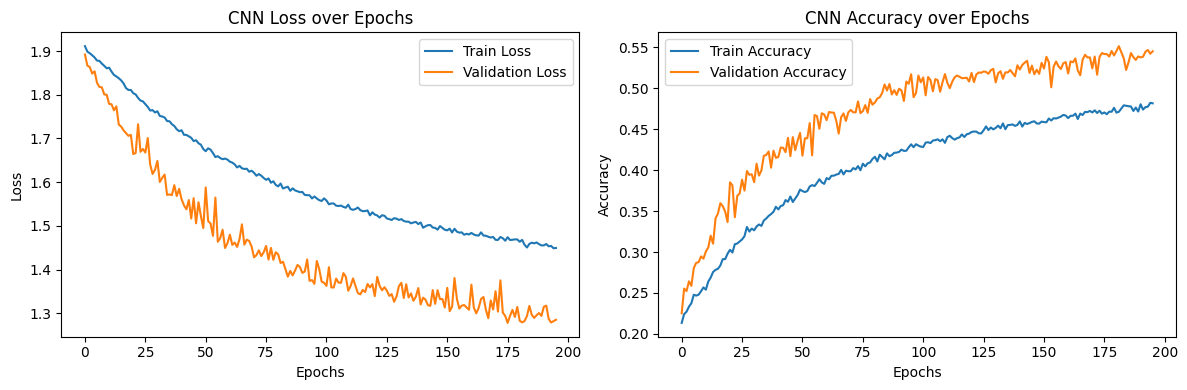

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step
Classification Report for CNN:
              precision    recall  f1-score   support

           0       0.45      0.37      0.41       958
           1       0.16      0.63      0.25       111
           2       0.39      0.12      0.18      1024
           3       0.81      0.74      0.77      1774
           4       0.44      0.65      0.53      1233
           5       0.44      0.40      0.42      1247
           6       0.59      0.76      0.67       831

    accuracy                           0.53      7178
   macro avg       0.47      0.52      0.46      7178
weighted avg       0.54      0.53      0.52      7178



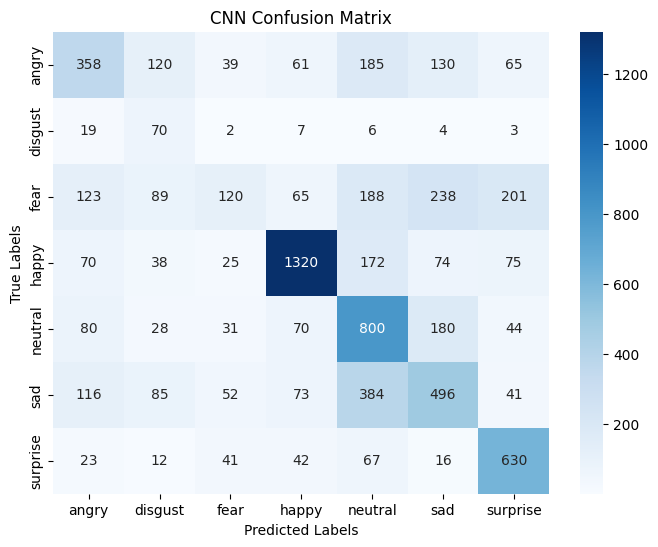

In [ ]:
plot_history_and_evaluate(best_model, cnn_ft_history, test_generator,'CNN')

## NASNet

In [ ]:
def build_nasnet_model(input_shape=(48, 48, 1), num_classes=7):
    # Create a Sequential model
    model = models.Sequential()

    # Add a Conv2D layer to convert grayscale to RGB
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Load the pre-trained NASNetMobile model
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # Add the base model
    model.add(base_model)

    # Add classification layers with BatchNormalization and Dropout
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tuning: Unfreeze specific layers
    for layer in base_model.layers[:150]:  # Unfreeze the first 150 layers
        layer.trainable = False
    for layer in base_model.layers[150:]:  # Unfreeze the remaining layers
        layer.trainable = True

    # Recompile after unfreezing
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


    return model


In [ ]:
# Build the model
nas_model = build_nasnet_model()

nas_ft_history = nas_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 149s 198ms/step - accuracy: 0.1466 - loss: 11.0650 - val_accuracy: 0.1411 - val_loss: 9.8721 - learning_rate: 1.0000e-04
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - accuracy: 0.1360 - loss: 9.8383 - val_accuracy: 0.1382 - val_loss: 8.7593 - learning_rate: 1.0000e-04
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 17s 95ms/step - accuracy: 0.1431 - loss: 8.5012 - val_accuracy: 0.1489 - val_loss: 7.3473 - learning_rate: 1.0000e-04
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 87ms/step - accuracy: 0.1401 - loss: 7.1653 - val_accuracy: 0.1332 - val_loss: 6.2363 - learning_rate: 1.0000e-04
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - accuracy: 0.1421 - loss: 6.0563 - val_accuracy: 0.1425 - val_loss: 5.6198 - learning_rate: 1.0000e-04
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.1511 - loss: 5.1545 - val_accuracy: 0.1368 - val_loss: 4.5981 - learning_rate: 1.0000e-04
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 17

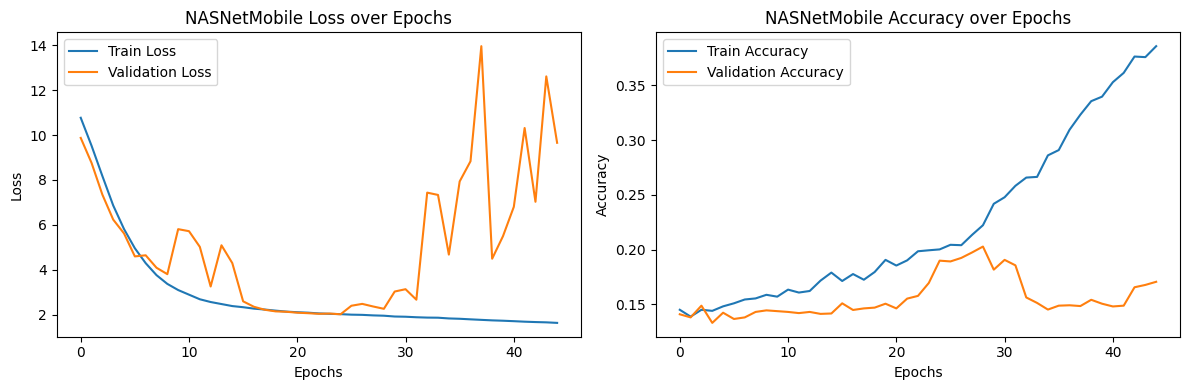

33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 392ms/step
Classification Report for NASNetMobile:
              precision    recall  f1-score   support

           0       0.20      0.12      0.15       300
           1       0.17      0.37      0.24       300
           2       0.19      0.17      0.18       300
           3       0.00      0.00      0.00       300
           4       0.00      0.00      0.00       300
           5       0.14      0.28      0.18       300
           6       0.29      0.36      0.32       300

    accuracy                           0.19      2100
   macro avg       0.14      0.19      0.15      2100
weighted avg       0.14      0.19      0.15      2100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


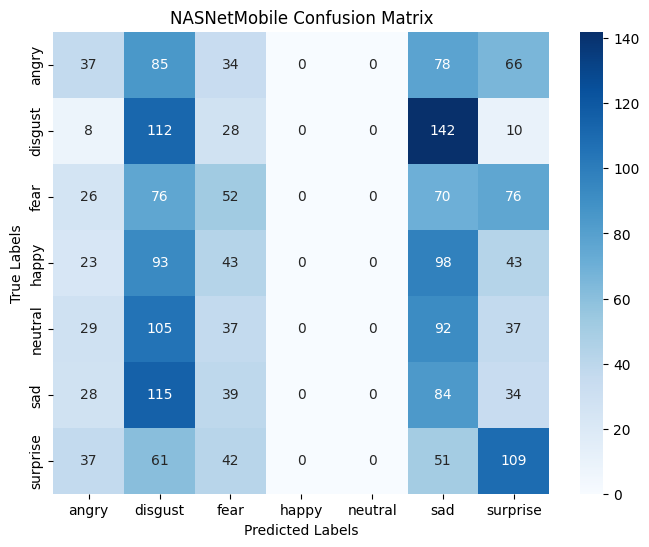

In [ ]:
plot_history_and_evaluate(nas_model, nas_ft_history, test_generator,'NASNetMobile')

## VGG16

In [ ]:
def build_vgg16_model(input_shape=(48, 48, 1), num_classes=7):
    # Create a Sequential model
    model = models.Sequential()

    # Add a Conv2D layer to convert grayscale to RGB
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Load the pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # Add the base model
    model.add(base_model)

    # Add classification layers with BatchNormalization and Dropout
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tuning: Unfreeze specific layers
    for layer in base_model.layers[:10]:
        layer.trainable = False
    for layer in base_model.layers[10:]:
        layer.trainable = True

    # Recompile after unfreezing
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Build the model
vgg_model = build_vgg16_model()

vgg_ft_history = vgg_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.1534 - loss: 9.0488 - val_accuracy: 0.1982 - val_loss: 7.3454 - learning_rate: 1.0000e-04
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.1753 - loss: 6.9646 - val_accuracy: 0.1429 - val_loss: 10.1810 - learning_rate: 1.0000e-04
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.1820 - loss: 5.5412 - val_accuracy: 0.1625 - val_loss: 4.9715 - learning_rate: 1.0000e-04
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.2156 - loss: 4.5725 - val_accuracy: 0.1993 - val_loss: 4.1081 - learning_rate: 1.0000e-04
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.2371 - loss: 4.0459 - val_accuracy: 0.2657 - val_loss: 3.6299 - learning_rate: 1.0000e-04
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.2341 - loss: 3.6904 - val_accuracy: 0.3257 - val_loss: 3.3059 - learning_rate: 1.0000e-04
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 

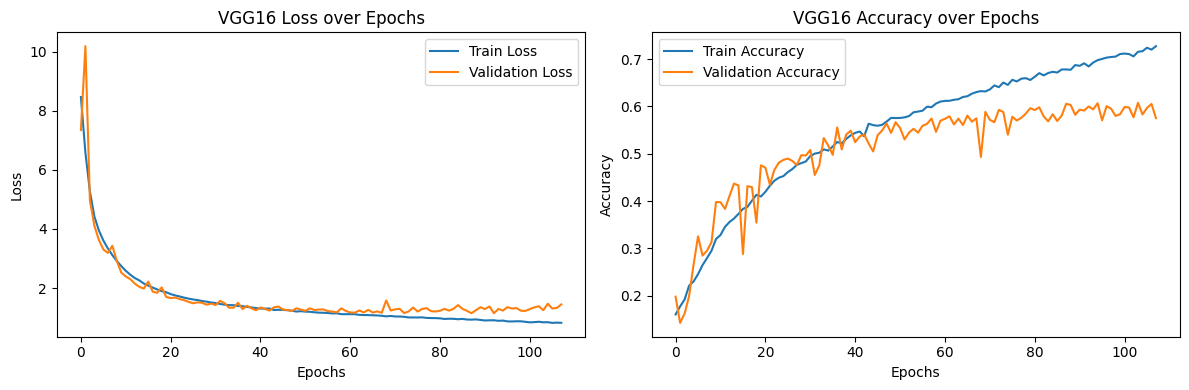

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.44      0.49      0.46       300
           1       0.85      0.69      0.76       300
           2       0.59      0.26      0.36       300
           3       0.66      0.79      0.72       300
           4       0.44      0.58      0.50       300
           5       0.44      0.49      0.47       300
           6       0.73      0.74      0.73       300

    accuracy                           0.58      2100
   macro avg       0.59      0.58      0.57      2100
weighted avg       0.59      0.58      0.57      2100



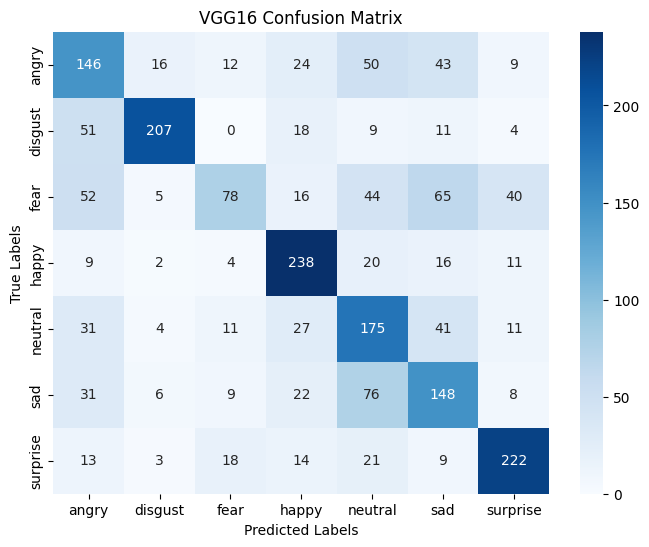

In [ ]:
plot_history_and_evaluate(vgg_model, vgg_ft_history, test_generator,'VGG16')

## ResNet50

In [ ]:
def build_resnet_model(input_shape=(48, 48, 1), num_classes=7):
    # Create a Sequential model
    model = models.Sequential()

    # Add a Conv2D layer to convert grayscale to RGB
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Load the pre-trained ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # Add the base model
    model.add(base_model)

    # Add classification layers with BatchNormalization and Dropout
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tuning: Unfreeze specific layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    for layer in base_model.layers[100:]:
        layer.trainable = True

    # Recompile after unfreezing
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Build the model
res_model = build_resnet_model()

res_ft_history = res_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=200,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 42s 109ms/step - accuracy: 0.1394 - loss: 12.4299 - val_accuracy: 0.1461 - val_loss: 10.9080 - learning_rate: 1.0000e-04
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.1418 - loss: 10.6272 - val_accuracy: 0.1532 - val_loss: 8.5693 - learning_rate: 1.0000e-04
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.1426 - loss: 8.2169 - val_accuracy: 0.1443 - val_loss: 7.6984 - learning_rate: 1.0000e-04
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.1489 - loss: 6.1972 - val_accuracy: 0.1721 - val_loss: 4.8837 - learning_rate: 1.0000e-04
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.1481 - loss: 4.7208 - val_accuracy: 0.1561 - val_loss: 3.9124 - learning_rate: 1.0000e-04
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.1541 - loss: 3.8709 - val_accuracy: 0.1557 - val_loss: 3.3768 - learning_rate: 1.0000e-04
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2

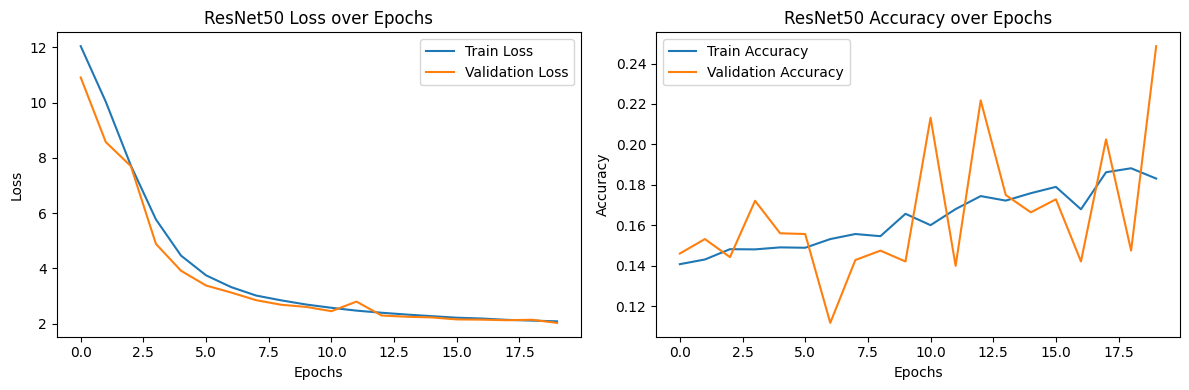

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step
Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.11      0.03      0.05       300
           1       0.00      0.00      0.00       300
           2       0.00      0.00      0.00       300
           3       0.14      0.96      0.25       300
           4       0.67      0.01      0.01       300
           5       0.00      0.00      0.00       300
           6       0.00      0.00      0.00       300

    accuracy                           0.14      2100
   macro avg       0.13      0.14      0.04      2100
weighted avg       0.13      0.14      0.04      2100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


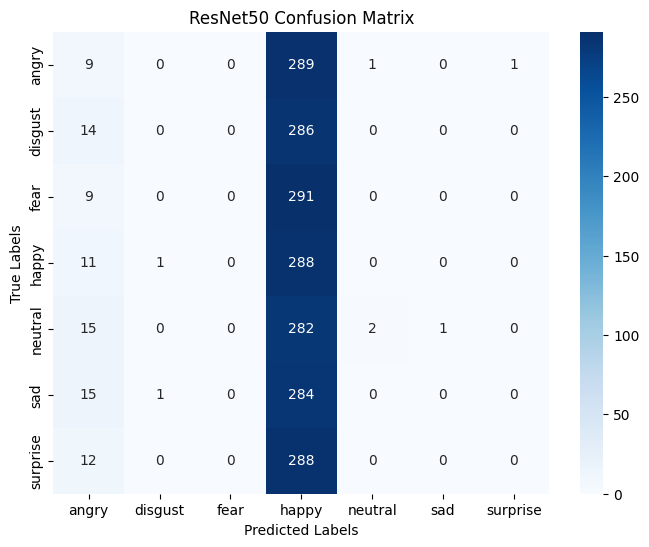

In [ ]:
plot_history_and_evaluate(res_model, res_ft_history, test_generator,'ResNet50')

# Input_shape=(75, 75, 1)

In [ ]:
train_generator, validation_generator, test_generator = create_data_generators(balanced_train_df, exp_test_df, image_size=(75, 75), batch_size=128, validation_split=0.3)

Found 19600 validated image filenames belonging to 7 classes.
Found 8400 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.


## InceptionV3

In [ ]:
def build_inceptionv3_model(input_shape=(75, 75, 1), num_classes=7):
    # Create a Sequential model
    model = models.Sequential()

    # Add a Conv2D layer to convert grayscale to RGB
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Load the pre-trained InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

    # Freeze the layers of the base model to retain the pre-trained features
    base_model.trainable = False

    # Add the base model
    model.add(base_model)

    # Add classification layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
ince_model = build_inceptionv3_model()
inc_em_history = train_model_with_early_stop(ince_model,train_generator, validation_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


154/154 ━━━━━━━━━━━━━━━━━━━━ 68s 292ms/step - accuracy: 0.1851 - loss: 1.9746 - val_accuracy: 0.2511 - val_loss: 1.8532
Epoch 2/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.2579 - loss: 1.8583 - val_accuracy: 0.2851 - val_loss: 1.8032
Epoch 3/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 43s 179ms/step - accuracy: 0.2700 - loss: 1.8277 - val_accuracy: 0.2980 - val_loss: 1.7864
Epoch 4/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.2836 - loss: 1.8078 - val_accuracy: 0.3076 - val_loss: 1.7685
Epoch 5/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 39s 163ms/step - accuracy: 0.2837 - loss: 1.8021 - val_accuracy: 0.3015 - val_loss: 1.7732
Epoch 6/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 161ms/step - accuracy: 0.2950 - loss: 1.7938 - val_accuracy: 0.3025 - val_loss: 1.7620
Epoch 7/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 163ms/step - accuracy: 0.2999 - loss: 1.7789 - val_accuracy: 0.3096 - val_loss: 1.7506
Epoch 8/50
154/154 ━━━━━━━━━━━━━━━━━━━━ 27s 169ms/step - accuracy: 0.3003 - loss: 1.7775 - val

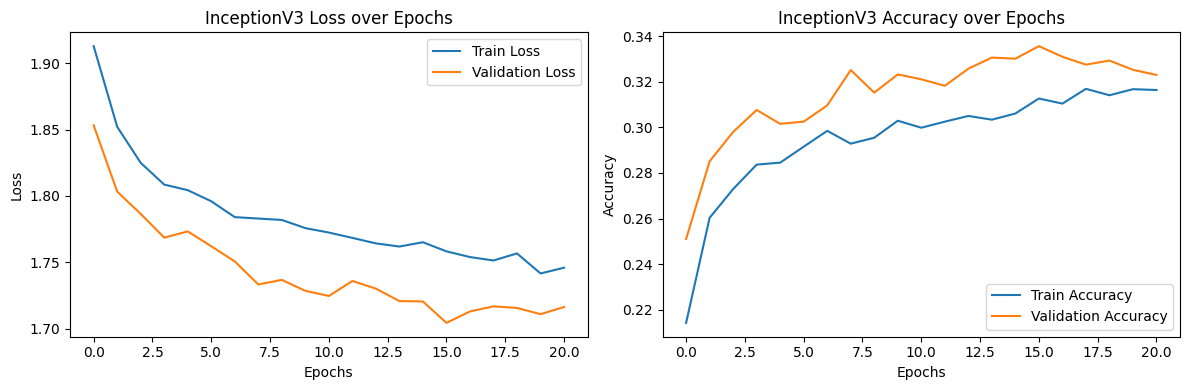

57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step
Classification Report for InceptionV3:
              precision    recall  f1-score   support

           0       0.21      0.08      0.11       958
           1       0.07      0.42      0.13       111
           2       0.23      0.08      0.12      1024
           3       0.46      0.50      0.48      1774
           4       0.31      0.34      0.32      1233
           5       0.34      0.24      0.28      1247
           6       0.34      0.69      0.45       831

    accuracy                           0.33      7178
   macro avg       0.28      0.34      0.27      7178
weighted avg       0.33      0.33      0.31      7178



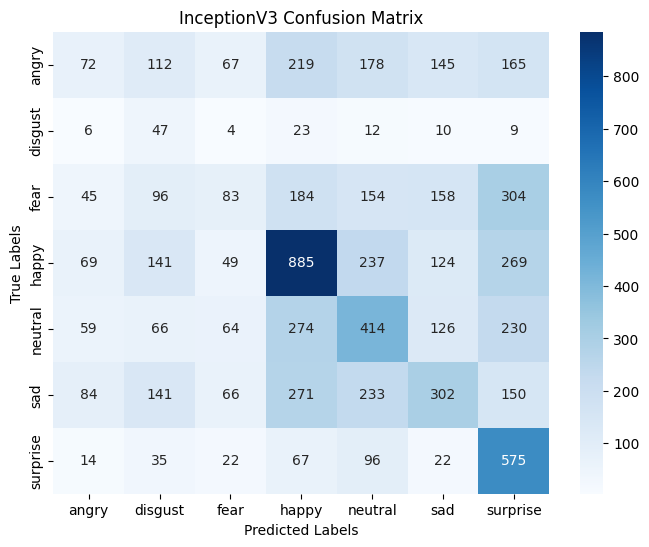

In [ ]:
plot_history_and_evaluate(ince_model, inc_em_history, test_generator,'InceptionV3')

## InceptionV3 with fine-tune

In [ ]:
def build_inceptionv3_model(input_shape=(75, 75, 1), num_classes=7):
    # Create a Sequential model
    model = models.Sequential()

    # Add a Conv2D layer to convert grayscale to RGB
    model.add(layers.Conv2D(3, (3, 3), padding='same', activation='relu', input_shape=input_shape))

    # Load the pre-trained InceptionV3 model
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(75, 75, 3))

    # Freeze all layers initially
    base_model.trainable = False

    # Add the base model
    model.add(base_model)

    # Add classification layers with BatchNormalization and Dropout
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.01), activation=None))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Fine-tuning: Unfreeze specific layers
    for layer in base_model.layers[:249]:
        layer.trainable = False
    for layer in base_model.layers[249:]:
        layer.trainable = True

    # Recompile after unfreezing
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
model = build_inceptionv3_model()

inc_ft_history = model.fit(train_generator, validation_data=validation_generator, epochs=200, callbacks=[early_stopping, reduce_lr])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.1516 - loss: 12.1910 - val_accuracy: 0.2246 - val_loss: 10.6990 - learning_rate: 1.0000e-04
Epoch 2/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step - accuracy: 0.1999 - loss: 9.8543 - val_accuracy: 0.2683 - val_loss: 8.1702 - learning_rate: 1.0000e-04
Epoch 3/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.2325 - loss: 7.8149 - val_accuracy: 0.2919 - val_loss: 6.5142 - learning_rate: 1.0000e-04
Epoch 4/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - accuracy: 0.2595 - loss: 6.2952 - val_accuracy: 0.3157 - val_loss: 5.2538 - learning_rate: 1.0000e-04
Epoch 5/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 165ms/step - accuracy: 0.2767 - loss: 5.1524 - val_accuracy: 0.3327 - val_loss: 4.4181 - learning_rate: 1.0000e-04
Epoch 6/200
154/154 ━━━━━━━━━━━━━━━━━━━━ 26s 164ms/step - accuracy: 0.2912 - loss: 4.3770 - val_accuracy: 0.3407 - val_loss: 3.8717 - learning_rate: 1.0000e-04
Epoch 7/200
154/154 ━━━━━━━━━━━━━━━━━━

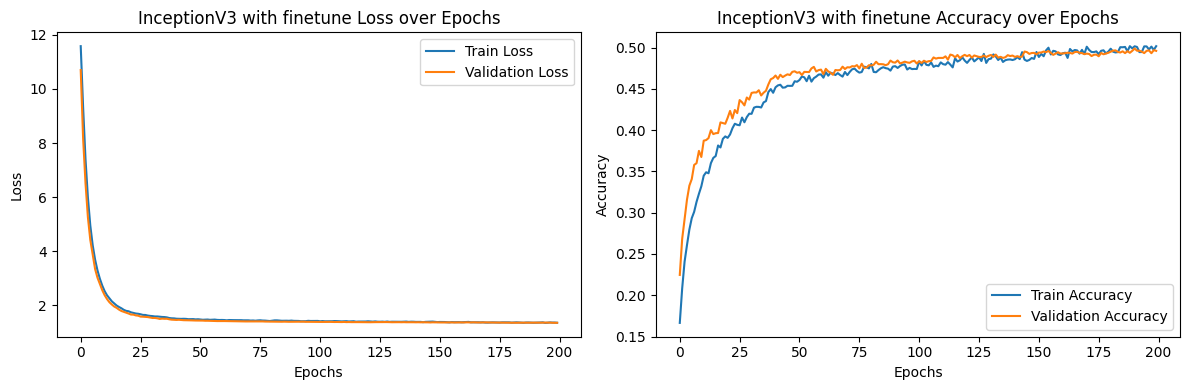

57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step
Classification Report for InceptionV3 with finetune:
              precision    recall  f1-score   support

           0       0.34      0.36      0.35       958
           1       0.23      0.62      0.34       111
           2       0.35      0.26      0.30      1024
           3       0.61      0.59      0.60      1774
           4       0.40      0.44      0.42      1233
           5       0.40      0.30      0.34      1247
           6       0.49      0.66      0.56       831

    accuracy                           0.45      7178
   macro avg       0.40      0.46      0.42      7178
weighted avg       0.45      0.45      0.44      7178



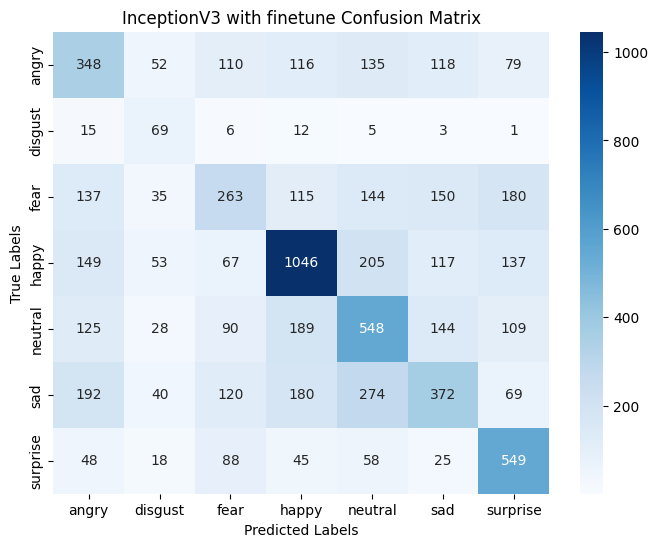

In [ ]:
plot_history_and_evaluate(model, inc_ft_history, test_generator,'InceptionV3 with finetune')